<a href="https://colab.research.google.com/github/NREL/BEEAM/blob/develop/FMU/flexlab_demo/5_notebooks/calibration_NMBE_CVRMSE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Purpose
This notebook calculates and plots the Normalized Mean Bias Error (NMBE) and Coefficient of Variation of the Root-Mean-Square Error
(CV[RMSE]) according to ASHRAE Guideline 14 using the data from the OpenStudio [Timeseries Objective Function Reporting Measure](https://github.com/NREL/openstudio-calibration-gem/tree/develop/lib/measures/TimeseriesObjectiveFunction). The plots are saved to My Drive (for public) or Shared drive (private).

In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import math
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns

# Setup

In [ ]:
# set to False if using private data from the research team 
public = True

# dirs
if public:
  csv_dir = '/content/drive/My Drive/BEEAM FLEXLAB Supporting Data/2 Calibration'
  out_dir = '/content/drive/My Drive'
else:
  csv_dir = '/content/drive/Shared drives/NREL DC Design Tool/Tasks/7 Validation/7.2 Whole Tool Validation/FLEXLAB/NREL OpenStudio Model/3 Calibration'
  out_dir = csv_dir
print(csv_dir)

# files
csv_name = 'timeseriesCalibration Arch Plnm.csv'
# csv_name = 'timeseriesCalibration Arch Zone.csv'
# csv_name = 'timeseriesCalibration Mech Clg.csv'
# csv_name = 'timeseriesCalibration Mech Fan.csv'
# csv_name = 'timeseriesUncalibrated Arch Plnm.csv'
# csv_name = 'timeseriesUncalibrated Arch Zone.csv'
# csv_name = 'timeseriesUncalibrated Mech Clg.csv'
# csv_name = 'timeseriesUncalibrated Mech Fan.csv'

# path
csv_path = os.path.join(csv_dir, csv_name)

# array of columns to remove (set to False if NA)
cols_to_drop = ['Metered time'] #False

# column names for calculations (must match renamed columns if applicable)
observed_column_name = 'Measured'
predicted_column_name = 'Modeled'

# array of desired column names, in order, after dropping, if applicable (set to False if NA)
col_name_dict = {'Simulation Time':'datetime',
                 'Simulated Value':predicted_column_name,
                 'Metered Value':observed_column_name}

# column index (after dropping or renaming columns)
col_index = 'datetime'

# beginning and end timestamps to slice dataset (if desired)
# in 'YYYY-MM-DD HH:MM:SS' format (set to False if NA)
beg = False
end = False

# plot title
title = csv_name.strip('timeseries').strip('.csv') #.strip('.').strip('_initial') #.strip('_') #'Architectural Test Plenum Temperature Calibration'
print(title)

# plot axis labels
xlabel = 'Date'
ylabel = 'Temperature (C)'
# ylabel = 'Cooling Load (W)'
# ylabel = 'Fan Power (W)'

# plot file name
png_name = title.replace(' ', '_').lower() + '.png'
print(png_name)
dpi = 300

# size
# aspect = 2

# plot observed and predicted colors
obs_clr = 'orange'
pre_clr = 'purple'

# yaxis min, max, and multiple for rounding
# if none, min and max will be rounded based on data and multiple

ymin = 18
ymax = 38
ymult = 1

# ymin = 0
# ymax = 2200 
# ymult = 1000 

# legend location
legend_location = 'upper left'
# legend_location = 'upper right'

/content/drive/Shared drives/NREL DC Design Tool/Tasks/7 Validation/7.2 Whole Tool Validation/FLEXLAB/NREL OpenStudio Model/3 Calibration
Calibration Arch Plnm
calibration_arch_plnm.png


# Extract

In [ ]:
# read csv
df = pd.read_csv(csv_path)

# show
df

,Simulation Time,Simulated Value,Metered time,Metered Value
0,2020/10/30 00:00:00,24.151821,2020/10/30 00:00:00,23.693248
1,2020/10/30 00:15:00,24.163727,2020/10/30 00:15:00,23.685806
2,2020/10/30 00:30:00,24.173884,2020/10/30 00:30:00,23.701334
3,2020/10/30 00:45:00,24.198034,2020/10/30 00:45:00,23.710255
4,2020/10/30 01:00:00,24.211865,2020/10/30 01:00:00,23.719775
...,...,...,...,...
542,2020/11/04 15:30:00,31.391449,2020/11/04 15:30:00,31.037000
543,2020/11/04 15:45:00,31.431297,2020/11/04 15:45:00,31.081442
544,2020/11/04 16:00:00,31.469713,2020/11/04 16:00:00,31.132390
545,2020/11/04 16:15:00,31.506308,2020/11/04 16:15:00,31.170452


# Transform

## Dataframe to Plot

In [ ]:
# drop columns
if len(cols_to_drop) > 0:
    df.drop(labels=cols_to_drop, axis=1, inplace=True)

# change column names
if len(col_name_dict) > 0:
    df.rename(columns=col_name_dict, inplace=True)

# convert column index to datetime format
df[col_index] = pd.to_datetime(df[col_index])

# set index
df.set_index(col_index, inplace=True)

# slice dataframe
if beg and not end:
    df = df[beg:df.index[-1]]
elif end and not beg:
    df = df[df.index[0]:end]
elif beg and end:
    df = df[beg:end]

# show dataframe
df

,Modeled,Measured
datetime,,
2020-10-30 00:00:00,24.151821,23.693248
2020-10-30 00:15:00,24.163727,23.685806
2020-10-30 00:30:00,24.173884,23.701334
2020-10-30 00:45:00,24.198034,23.710255
2020-10-30 01:00:00,24.211865,23.719775
...,...,...
2020-11-04 15:30:00,31.391449,31.037000
2020-11-04 15:45:00,31.431297,31.081442
2020-11-04 16:00:00,31.469713,31.132390


## Dataframe for Calculations

In [ ]:
# new dataframe for calculations
df_calcs = df.copy()

# calculate difference of predicted and observed for NMBE
df_calcs['(obs - pre)'] = df_calcs[observed_column_name] - df_calcs[predicted_column_name]
df_calcs

# calculate the square of the difference for CV(RMSE)
df_calcs['(obs - pre)^2'] = df_calcs['(obs - pre)']**2
df_calcs

,Modeled,Measured,(obs - pre),(obs - pre)^2
datetime,,,,
2020-10-30 00:00:00,24.151821,23.693248,-0.458573,0.210289
2020-10-30 00:15:00,24.163727,23.685806,-0.477921,0.228408
2020-10-30 00:30:00,24.173884,23.701334,-0.472550,0.223304
2020-10-30 00:45:00,24.198034,23.710255,-0.487779,0.237928
2020-10-30 01:00:00,24.211865,23.719775,-0.492090,0.242153
...,...,...,...,...
2020-11-04 15:30:00,31.391449,31.037000,-0.354449,0.125634
2020-11-04 15:45:00,31.431297,31.081442,-0.349855,0.122399
2020-11-04 16:00:00,31.469713,31.132390,-0.337323,0.113787


# Load

## Calculate NMBE and CV(RMSE)

$ NMBE = \sum_{i=1}^n (y_i - \hat{y_i} ) / (n - p) * \bar{y} $

$ CV(RMSE) = \sqrt{ \sum{ (y_i - \hat{y_i})^2 } / (n - p) } / \bar{y} $

where

> $ y_i = $ single observed (measured) value
>
> $ \hat{y_i} = $ single predicted (modeled) value
>
> $ n = $ number of data points or periods
>
> $ p = $ number of parameters or terms in the
baseline model
>
> $ \bar{y} = $ arithmetic mean of the sample of n
observations


In [ ]:
# NMBE sum
nmbe_sum = df_calcs['(obs - pre)'].sum()
print(f'NMBE sum = {nmbe_sum}')

# sum of sqaures for CV(RMSE)
cvrmse_sum = df_calcs['(obs - pre)^2'].sum()
print(f'CV(RMSE) sum = {cvrmse_sum}')

# number of data points
n = len(df_calcs.index)
print(f'n = {n}')

# number of parameters
p = 1

# mean of samples
y_bar = df_calcs[observed_column_name].mean()
print(f'y_bar = {y_bar}')

print('')

# calculate NMBE
nmbe = nmbe_sum / ((n - p) * y_bar)
nmbe_pct = nmbe * 100
print(f'NMBE = {nmbe}')

# calculate CV(RMSE)
cvrmse = (cvrmse_sum / (n - p))**0.5 / y_bar
cvrmse_pct = cvrmse * 100
print(f'CV(RMSE) = {cvrmse}')

NMBE sum = 13.61792999999999
CV(RMSE) sum = 29.070343348682037
n = 547
y_bar = 28.874422910420478

NMBE = 0.0008637839728828893
CV(RMSE) = 0.007991263408973565


## Plot

In [ ]:
df.describe()

,Modeled,Measured
count,547.000000,547.000000
mean,34.458920,34.462807
std,2.851508,2.911484
min,25.477778,25.642054
25%,32.978199,32.763966
50%,35.914022,35.586082
75%,36.356211,36.315715
max,37.172744,37.488719


In [ ]:
# get min and max for axis scale
pre_min = df[predicted_column_name].min()
pre_max = df[predicted_column_name].max()

obs_min = df[observed_column_name].min()
obs_max = df[observed_column_name].max()

abs_min = min(pre_min, obs_min)
abs_max = max(pre_max, obs_max)
print(abs_min, abs_max)

# yaxis minimum value
if ymin == None:
    rnd_min = abs_min - abs_min % ymult # math.floor(abs_min)
else:
    rnd_min = ymin

# yaxis maximum value
if ymax == None:
    rnd_max = math.ceil(abs_max / ymult) * ymult #round(abs_max, -1)
else:
    rnd_max = ymax

print(rnd_min, rnd_max)

# get max time for annotation location
# time_max = df.index[-1]
# time_max

23.685806 31.540736
18 38


(18.0, 38.0)

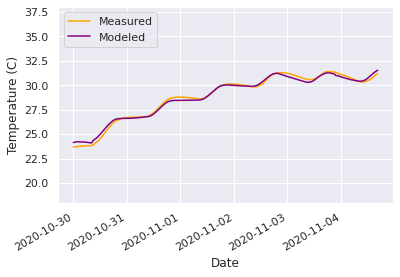

In [ ]:
# use Seaborn's default theme
sns.set_theme()

# create figure and axis
fig, ax = plt.subplots()

# set title and axis labels
# ax.set_title(title)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

# add data
ax.plot(df.index, df[observed_column_name], label=observed_column_name, color=obs_clr)
ax.plot(df.index, df[predicted_column_name], label=predicted_column_name, color=pre_clr)

# add legend
ax.legend(loc=legend_location) #bbox_to_anchor=(1, 1), loc='center right') #loc='best')

# format x-axis
ax.figure.autofmt_xdate()

# format y-axis
ax.set_ylim(ymin=rnd_min, ymax=rnd_max)

0.1% NMBE
0.8% CV(RMSE)


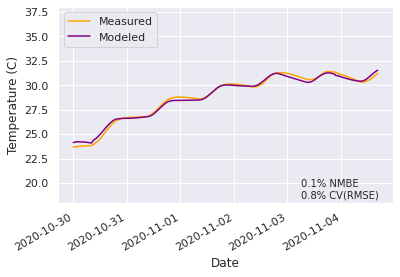

In [ ]:
# annotation text, note s is a deprecated synonym for text
text = f'{nmbe_pct:.1f}% NMBE\n{cvrmse_pct:.1f}% CV(RMSE)'
print(text)

# add (or remove) annotation
annotation = ax.annotate(s=text, xy=(0.725, 0.025), xycoords='axes fraction', fontsize=10)
# annotation.remove()

fig

In [ ]:
# save
fig.savefig(os.path.join(out_dir, png_name), bbox_inches='tight', dpi=dpi)